In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ParameterGrid
from tqdm.notebook import tqdm, trange
import pandas as pd
from time import time

# архитектура полносвязной нейронной сети
class FullyConnectedNLayersNet(nn.Module):
    def __init__(self, n_layers=10, n_weights=10, activation=torch.sin,
                #  dropout_p=0
                 ):

        '''
        Конструктор для класса полносвязной нейронной сети

        params:
            int n_layers : кол-во слоёв, учитывая входной и выходной
            int n_weights : кол-во нейронов в каждом из слоёв
            torch function activation : функция активации
        '''

        super(FullyConnectedNLayersNet, self).__init__()
        self.activation = activation
        self.n_layers = n_layers
        self.n_weights = n_weights
        self.fc0 = nn.Linear(1, n_weights)
        # self.batchnorm0 = nn.BatchNorm1d(n_weights)
        for i in range(1, n_layers - 1):
            setattr(self, f'fc{i}', nn.Linear(n_weights, n_weights))
            # setattr(self, f'batchnorm{i}', nn.BatchNorm1d(n_weights))
        # self.dropout = nn.Dropout(dropout_p)
        setattr(self, f'fc{n_layers - 1}', nn.Linear(n_weights, 1))

    def forward(self, x):
        for i in range(self.n_layers - 1):
            x = getattr(self, f'fc{i}')(x)
            # x = getattr(self, f'batchnorm{i}')(x)
            x = self.activation(x)
            # x = self.dropout(x)
        x = getattr(self, f'fc{self.n_layers - 1}')(x)
        return x

In [ ]:
def info(init_condition_loss, equation_loss, approximate_solution_loss,
         full_loss,
         epoch_num):

    '''
    Вывод информации о процессе обучения

    param:
        numpy.float64 init_condition_loss : значение лосса на начальные условия на текущей эпохе
        numpy.float64 equation_loss : значение лосса на "дифференциальное уравнение" на текущей эпохе
        numpy.float64 approximate_solution_loss : значение лосса на приближеннре решение на текущей эпохе
        numpy.float64 full_loss : полное значение лосса на текущей эпохе
        int epoch_num : номер текущей эпохи
    '''

    print(f'epoch: {epoch_num}\n')
    print(f'\tinit_condition_loss: {format(round(init_condition_loss, 5), ".5f")}')
    print(f'\tequation_loss: {format(round(equation_loss, 5), ".5f")}')
    print(f'\tapproximate_solution_loss: {format(round(approximate_solution_loss, 5), ".5f")}\n')
    print(f'\n\tfull_loss: {format(round(full_loss, 7), ".7f")}')
    print('-' * 60)

def plot_losses(losses):

    '''
    Вывод графика изменения лоссов

    '''

    plt.figure(figsize=(12, 10))
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle('fit process', y=0.94, fontsize=18)
    i = 0
    for name, loss in losses.items():
        if name == "full_loss" or name == 'epoch':
            continue
        i += 1
        plt.subplot(3, 3, i)
        plt.plot(losses['epoch'], loss)
        plt.title(f"{name}")
        plt.gca().set_xlabel('epoch')
    plt.show()
    plt.subplot(1, 1, 1)
    plt.plot(losses['epoch'], losses['full_loss'])
    plt.title('full_loss')
    plt.gca().set_xlabel('epoch')
    plt.show()

def plot_real_solution_diff(epochs, real_solution_losses):

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, real_solution_losses)
    plt.xlabel('epoch')
    plt.ylabel('model and real solution difference')
    plt.show()

In [ ]:
def fit(model,
        init_condition, equation, approximate_solution,
        loss_weights,
        real_solution=None,
        optimize: dict = None,
        batch_size = 100, max_epochs = 300,
        p=10,
        print_info: int = 0, plot_result = False,
        stopping_criterion: dict = None):

    '''
    function approximate_solution : функция, которая принимает и возвращает одномерный torch массив
    '''

    if optimize is None:
        optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}}

    if stopping_criterion is None:
        stopping_criterion = {'loss': 0.0001}
        stopping_criterion['triggered'] = False

    if print_info != 0:
        print('-' * 60)

    # лосс на начальные условия
    init_condition_criterion = nn.MSELoss()
    # лосс на "дифференциальное уравнение"
    equation_criterion = nn.MSELoss()
    # лосс на приближенное решение
    approximate_solution_criterion = nn.MSELoss()
    if real_solution is not None:
        # лосс на точное решение
        real_solution_criterion = nn.MSELoss()

    # задаём метод оптимизации и его параметры
    optimizer = optimize['optimizer'](model.parameters(), **optimize['params'])

    init_condition = torch.tensor([init_condition], dtype=torch.double)

    losses = {'epoch': [],
              'init_condition_loss': [],
              'equation_loss': [],
              'approximate_solution_loss': [],
              'full_loss': []}
    if real_solution is not None:
        losses['real_solution_diff'] = []

    epochs = max_epochs
    model.train()
    for epoch_num in trange(max_epochs):

        epoch_loss = 0

        # обновляем трейновые точки
        t = torch.rand(batch_size, dtype=torch.double)

        # выход модели
        N = torch.flatten(model(t.view(-1, 1)))
        # значение "дифференциального уравнения"
        equation_batch = torch.flatten(equation(model, t.view(-1, 1)))
        # значение приближенного решения
        approximate_solution_train_batch = approximate_solution(t)

        init_condition_loss = init_condition_criterion(torch.flatten(model(torch.zeros(1, dtype=torch.double).view(-1, 1))), init_condition) * loss_weights[0]

        equation_loss = equation_criterion(torch.flatten(torch.autograd.functional.jacobian(model, t.view(-1, 1), create_graph=True).sum(dim=0)), equation_batch) * loss_weights[1]

        approximate_solution_loss = approximate_solution_criterion(N, approximate_solution_train_batch) * loss_weights[2]

        # Lp норма - ...
        train_loss = ((init_condition_loss + equation_loss + approximate_solution_loss) ** p) ** (1 / p)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if real_solution is not None:
            real_solution_batch = real_solution(t)
            real_solution_diff = torch.sqrt(real_solution_criterion(N, real_solution_batch))

        losses['epoch'].append(epoch_num + 1)
        losses['init_condition_loss'].append(init_condition_loss.item())
        losses['equation_loss'].append(equation_loss.item())
        losses['approximate_solution_loss'].append(approximate_solution_loss.item())
        losses['full_loss'].append(train_loss.item())
        if real_solution is not None:
            losses['real_solution_diff'].append(real_solution_diff.item())

        # вывод средней ошибки по каждому лоссу на каждой эпохе и её вклад в сумму
        if print_info and ((epoch_num % print_info == 0) or epoch_num + 1 == epochs):
            info(losses['init_condition_loss'][-1], losses['equation_loss'][-1], losses['approximate_solution_loss'][-1],
                 losses['full_loss'][-1],
                 epoch_num + 1)

        if stopping_criterion:
            if list(stopping_criterion.keys())[0] == 'loss':
                if train_loss.item() <= stopping_criterion['loss']:
                    epochs = epoch_num + 1
                    stopping_criterion['triggered'] = True
                    if print_info:
                        info(losses['init_condition_loss'][-1], losses['equation_loss'][-1], losses['approximate_solution_loss'][-1],
                             losses['full_loss'][-1],
                             epochs)
                    break

    # график изменения функций потерь
    if plot_result:
        plot_losses(losses)
        if stopping_criterion and set(stopping_criterion) == {'loss', 'triggered'}:
            print(f"total epochs - {epochs}, stopping criterion: triggered - {stopping_criterion['triggered']}, loss - {format(losses['full_loss'][-1], '.5f')}")

    if plot_result and real_solution:
        plot_real_solution_diff(losses['epoch'], losses['real_solution_diff'])

    return losses

In [ ]:
def plot_model(model, equation, approximate_solution, xrange=(0, 1), sample_size = 100, style=('plot', 'plot'), title=None):

    model.to('cpu')

    model.eval()
    with torch.no_grad():

        t = (torch.sort((xrange[1] - xrange[0]) * torch.rand(sample_size, dtype=torch.double) + xrange[0])[0])

        plt.figure(figsize=(10, 4))

        plt.subplot(122)
        getattr(plt, style[1])(t, torch.flatten(torch.autograd.functional.jacobian(model, t.view(-1, 1), create_graph=True).sum(dim=0)).detach().numpy(),
                               label='derivative of the model')
        getattr(plt, style[1])(t, torch.flatten(equation(model, t.view(-1, 1))),
                               label='equation(model(t), t)')
        plt.gca().set_title('derivative of the solution')
        plt.legend()
        plt.gca().set_xlabel('t')

        plt.subplot(121)
        getattr(plt, style[0])(t, torch.flatten(model(t.view(-1, 1))).detach().numpy(),
                               label='model prediction')
        getattr(plt, style[0])(t, approximate_solution(t),
                               label='approximate solution')
        plt.gca().set_title('solution of the differential equation')
        plt.legend()
        plt.gca().set_xlabel('t')

        if title is not None:
            plt.suptitle(title, x=0.52, y=1.05, fontsize=18)

        plt.show()

In [ ]:
def fit_search(estimator, model_params=None, ready_fit_params=None, fit_params=None, num_runs=5, print_results=False):

    if model_params is None:
        model_params = {}

    assert ready_fit_params is not None, "Необходимо передать выборку для обучения"

    assert fit_params is not None, "Необходимо передать гиперпараметры для перебора"

    if ready_fit_params is None:
        ready_fit_params = {}

    params_grid = ParameterGrid(fit_params)

    results = {}
    results['params'] = []
    for i in range(num_runs):
        results[f'run{i}_init_condition_loss'] = []
        results[f'run{i}_equation_loss'] = []
        results[f'run{i}_approximate_solution_loss'] = []
        results[f'run{i}_full_loss'] = []
    results['mean_runs_init_condition_loss'] = []
    results['mean_runs_equation_loss'] = []
    results['mean_runs_approximate_solution_loss'] = []
    results['mean_runs_full_loss'] = []
    results['std_runs_init_condition_loss'] = []
    results['std_runs_equation_loss'] = []
    results['std_runs_approximate_solution_loss'] = []
    results['std_runs_full_loss'] = []
    results['mean_runs_fit_time'] = []
    results['std_runs_fit_time'] = []

    if print_results:
        print('-' * 60)

    for comb in tqdm(params_grid):

        results['params'].append(comb)

        init_condition_loss_mean = 0
        equasion_loss_mean = 0
        approximate_solution_loss_mean = 0
        full_loss_mean = 0

        init_condition_loss_std = 0
        equasion_loss_std = 0
        approximate_solution_loss_std = 0
        full_loss_std = 0

        fit_time_mean = 0
        fit_time_std = 0

        for i in range(num_runs):

            model = estimator(**model_params).double()

            start_time = time()
            losses = fit(model=model, **ready_fit_params, **comb)
            end_time = time()

            results[f'run{i}_init_condition_loss'].append(losses['init_condition_loss'][-1])
            results[f'run{i}_equation_loss'].append(losses['equation_loss'][-1])
            results[f'run{i}_approximate_solution_loss'].append(losses['approximate_solution_loss'][-1])
            results[f'run{i}_full_loss'].append(losses['full_loss'][-1])

            init_condition_loss_mean += losses['init_condition_loss'][-1]
            equasion_loss_mean += losses['equation_loss'][-1]
            approximate_solution_loss_mean += losses['approximate_solution_loss'][-1]
            full_loss_mean += losses['full_loss'][-1]

            init_condition_loss_std += losses['init_condition_loss'][-1] ** 2
            equasion_loss_std += losses['equation_loss'][-1] ** 2
            approximate_solution_loss_std += losses['approximate_solution_loss'][-1] ** 2
            full_loss_std += losses['full_loss'][-1] ** 2

            fit_time_mean += end_time - start_time
            fit_time_std += (end_time - start_time) ** 2

        results['mean_runs_init_condition_loss'].append(init_condition_loss_mean / num_runs)
        results['mean_runs_equation_loss'].append(equasion_loss_mean / num_runs)
        results['mean_runs_approximate_solution_loss'].append(approximate_solution_loss_mean / num_runs)
        results['mean_runs_full_loss'].append(full_loss_mean / num_runs)

        results['std_runs_init_condition_loss'].append(np.sqrt((num_runs / (num_runs - 1)) * (init_condition_loss_std / num_runs - (init_condition_loss_mean / num_runs) ** 2)))
        results['std_runs_equation_loss'].append(np.sqrt((num_runs / (num_runs - 1)) * (equasion_loss_std / num_runs - (equasion_loss_mean / num_runs) ** 2)))
        results['std_runs_approximate_solution_loss'].append(np.sqrt((num_runs / (num_runs - 1)) * (approximate_solution_loss_std / num_runs - (approximate_solution_loss_mean / num_runs) ** 2)))
        results['std_runs_full_loss'].append(np.sqrt((num_runs / (num_runs - 1)) * (full_loss_std / num_runs - (full_loss_mean / num_runs) ** 2)))

        results['mean_runs_fit_time'].append(fit_time_mean / num_runs)
        results['std_runs_fit_time'].append(np.sqrt((num_runs / (num_runs - 1)) * (fit_time_std / num_runs - (fit_time_mean / num_runs) ** 2)))

        if print_results:
            print(f'params: {comb}')
            print(f'\tmean_runs_full_loss: {format(round(full_loss_mean / num_runs, 5), ".5f")}')
            print(f'\tstd_runs_full_loss: {format(round(np.sqrt((num_runs / (num_runs - 1)) * (full_loss_std / num_runs - (full_loss_mean / num_runs) ** 2)), 5), ".5f")}')
            print(f'\tmean_runs_fit_time: {round(fit_time_mean / num_runs)}s')
            print(f'\tstd_runs_fit_time: {format(round(np.sqrt((num_runs / (num_runs - 1)) * (fit_time_std / num_runs - (fit_time_mean / num_runs) ** 2)), 2), ".2")}s')
            print('-' * 60)

    return results

In [ ]:
max_epochs = 300
num_runs = 30
noise_stds = [0.001, 0.01, 0.1, 1]

In [ ]:
model_1 = FullyConnectedNLayersNet().double()

init_condition_1 = 1

def equation_1(x_, t_):
    return x_(t_)

def approximate_solution_1_template(noise_std=0.01):
    def approximate_solution_1(t_):
        return torch.exp(t_) + (noise_std * torch.normal(torch.zeros(len(t_), dtype=torch.double), torch.ones(len(t_), dtype=torch.double)))
    return approximate_solution_1

def real_solution_1(t_):
    return torch.exp(t_)

In [ ]:
# res_1 = fit(model_1,
#             init_condition_1, equation_1, approximate_solution_1_template(),
#             loss_weights = [1/3, 1/3, 1/3],
#             optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
#             batch_size = 100, max_epochs = 500,
#             p=10,
#             print_info = 25, plot_result = True)

# plot_model(model_1, equation_1, approximate_solution_1_template(), title=r'$\dfrac{dx}{dt}=x(t)$')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

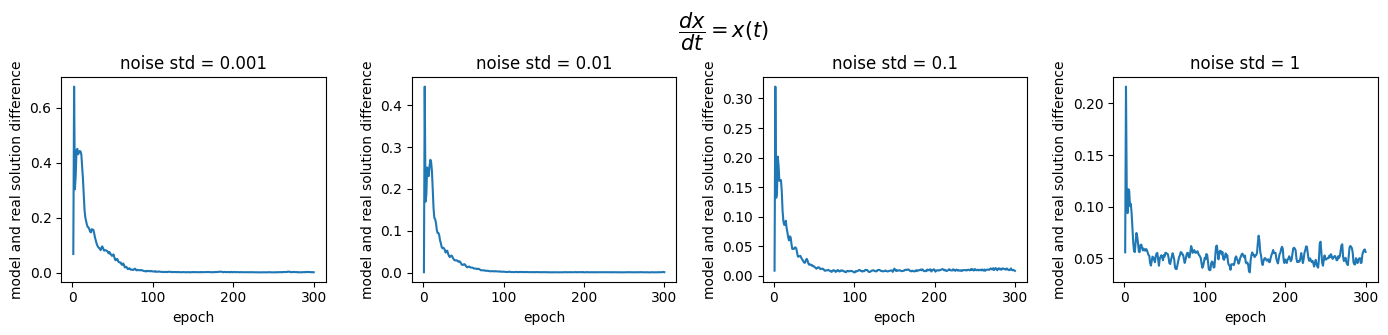

In [ ]:
mean_runs_real_solution_diff_1 = {'noise_std': noise_stds, 'difference': []}

plt.figure(figsize=(14, 3))
for i, noise_std in enumerate(tqdm(noise_stds), start=1):

    difference = torch.zeros(max_epochs, dtype=torch.double)
    for run in trange(num_runs):

        res = fit(model_1,
                  init_condition_1, equation_1, approximate_solution_1_template(noise_std),
                  loss_weights = [1/3, 1/3, 1/3],
                  real_solution = real_solution_1,
                  optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
                  batch_size = 100, max_epochs = max_epochs,
                  p=10,
                  print_info = 0, plot_result = False,
                  stopping_criterion = False)

        difference += torch.Tensor(res['real_solution_diff'])

    mean_runs_real_solution_diff_1['difference'].append(difference / num_runs)

    plt.subplot(1, 4, i)
    plt.plot(np.arange(1, max_epochs + 1), mean_runs_real_solution_diff_1['difference'][-1].detach().numpy())
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('model and real solution difference')
    plt.gca().set_title(f'noise std = {noise_std}')
plt.tight_layout()
plt.suptitle(r'$\dfrac{dx}{dt}=x(t)$', x=0.52, y=1.1, fontsize=15);

In [ ]:
model_2 = FullyConnectedNLayersNet().double()

init_condition_2 = 1

def equation_2(x_, t_):
    return torch.sin(t_)

def approximate_solution_2_template(noise_std=0.01):
    def approximate_solution_2(t_):
        return -torch.cos(t_) + 2 * torch.ones(len(t_), dtype=torch.double) + (noise_std * torch.normal(torch.zeros(len(t_), dtype=torch.double), torch.ones(len(t_), dtype=torch.double)))
    return approximate_solution_2

def real_solution_2(t_):
    return -torch.cos(t_) + 2 * torch.ones(len(t_), dtype=torch.double)

In [ ]:
# fit(model_2,
#     init_condition_2, equation_2, approximate_solution_2_template(),
#     loss_weights = [1/3, 1/3, 1/3],
#     optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
#     batch_size = 100, max_epochs = 500,
#     p=10,
#     proportions=True,
#     print_info = 25, plot_result=True)

# plot_model(model_2, equation_2, approximate_solution_2_template(), title=r'$\dfrac{dx}{dt}=sin(t)$')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

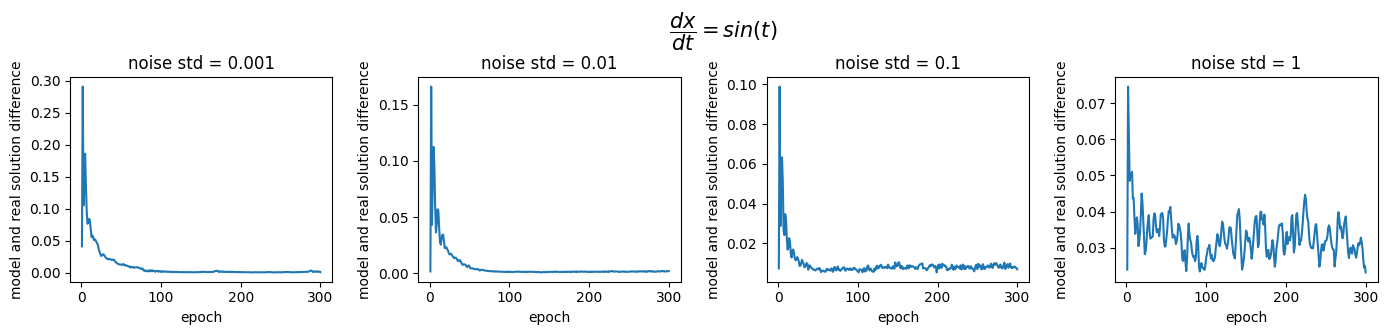

In [ ]:
mean_runs_real_solution_diff_2 = {'noise_std': noise_stds, 'difference': []}

plt.figure(figsize=(14, 3))
for i, noise_std in enumerate(tqdm(noise_stds), start=1):

    difference = torch.zeros(max_epochs, dtype=torch.double)
    for run in trange(num_runs):

        res = fit(model_2,
                  init_condition_2, equation_2, approximate_solution_2_template(noise_std),
                  loss_weights = [1/3, 1/3, 1/3],
                  real_solution = real_solution_2,
                  optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
                  batch_size = 100, max_epochs = max_epochs,
                  p=10,
                  print_info = 0, plot_result = False,
                  stopping_criterion = False)

        difference += torch.Tensor(res['real_solution_diff'])

    mean_runs_real_solution_diff_2['difference'].append(difference / num_runs)

    plt.subplot(1, 4, i)
    plt.plot(np.arange(1, max_epochs + 1), mean_runs_real_solution_diff_2['difference'][-1].detach().numpy())
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('model and real solution difference')
    plt.gca().set_title(f'noise std = {noise_std}')
plt.tight_layout()
plt.suptitle(r'$\dfrac{dx}{dt}=sin(t)$', x=0.52, y=1.1, fontsize=15);

In [ ]:
model_3 = FullyConnectedNLayersNet().double()

init_condition_3 = 1

def equation_3(x_, t_):
    return 1 / (torch.cos(t_) ** 2)

def approximate_solution_3_template(noise_std=0.01):
    def approximate_solution_3(t_):
        return torch.tan(t_) + torch.ones(len(t_), dtype=torch.double) + (noise_std * torch.normal(torch.zeros(len(t_), dtype=torch.double), torch.ones(len(t_), dtype=torch.double)))
    return approximate_solution_3

def real_solution_3(t_):
    return torch.tan(t_) + torch.ones(len(t_), dtype=torch.double)

In [ ]:
# fit(model_3,
#     init_condition_3, equation_3, approximate_solution_3_template(),
#     loss_weights = [1/3, 1/3, 1/3],
#     optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
#     batch_size = 100, max_epochs = 700,
#     p=10,
#     proportions=True,
#     print_info = 25, plot_result=True)

# plot_model(model_3, equation_3, approximate_solution_3_template(), title=r'$\dfrac{dx}{dt}=\dfrac{1}{cos^2(t)}$')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

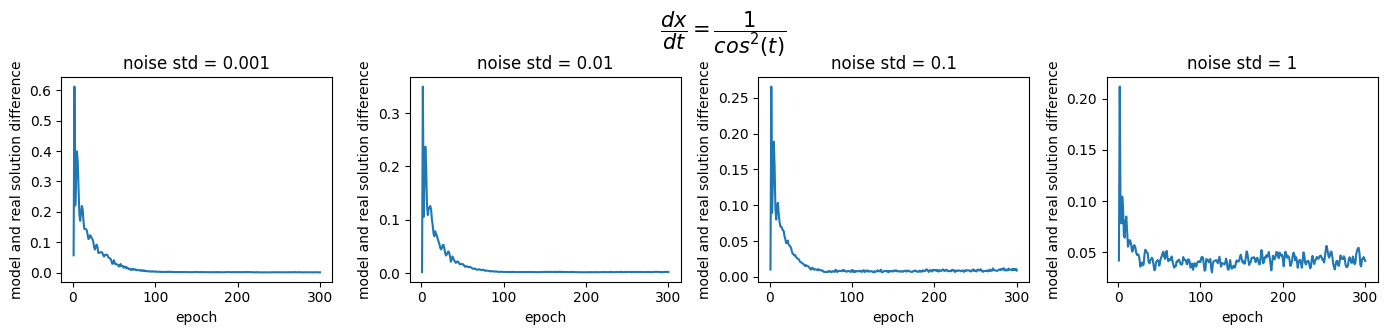

In [ ]:
mean_runs_real_solution_diff_3 = {'noise_std': noise_stds, 'difference': []}

plt.figure(figsize=(14, 3))
for i, noise_std in enumerate(tqdm(noise_stds), start=1):

    difference = torch.zeros(max_epochs, dtype=torch.double)
    for run in trange(num_runs):

        res = fit(model_3,
                  init_condition_3, equation_3, approximate_solution_3_template(noise_std),
                  loss_weights = [1/3, 1/3, 1/3],
                  real_solution = real_solution_3,
                  optimize = {'optimizer': torch.optim.Adam, 'params': {'lr': 0.01}},
                  batch_size = 100, max_epochs = max_epochs,
                  p=10,
                  print_info = 0, plot_result = False,
                  stopping_criterion = False)

        difference += torch.Tensor(res['real_solution_diff'])

    mean_runs_real_solution_diff_3['difference'].append(difference / num_runs)

    plt.subplot(1, 4, i)
    plt.plot(np.arange(1, max_epochs + 1), mean_runs_real_solution_diff_3['difference'][-1].detach().numpy())
    plt.gca().set_xlabel('epoch')
    plt.gca().set_ylabel('model and real solution difference')
    plt.gca().set_title(f'noise std = {noise_std}')
plt.tight_layout()
plt.suptitle(r'$\dfrac{dx}{dt}=\dfrac{1}{cos^2(t)}$', x=0.52, y=1.1, fontsize=15);